In [1]:
#Dan's Notes: ordinal encoding for  Utilities as follows : 4-AllPub 3-NoSewr 2-NoSeWa 1-ELO
# ordinal encoding for OverallQual & OverallCond & ExterQual & ExterCond & BsmtQual & BsmtCond as per condition 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
class PreProcessing():
    def __init__(self, df : pd.DataFrame = pd.DataFrame) :
        self.df = df
        
    
    def Information (self , df) :
        self.df = df
        df.replace('?' , np.nan , inplace = True )
        nulls = (df.shape[0] - df.dropna(axis = 0).shape[0])
        nulls_per = (df.shape[0] - df.dropna(axis = 0).shape[0]) / df.shape[0]
        dup , dup_per = df.duplicated().sum() , (df.duplicated().sum()) / df.shape[0]
        numerical_columns = list((df.select_dtypes(include=np.number)).columns)
        categorical_columns = list(df.select_dtypes(include = ['object']).columns)
        numerical_col_dict = {}
        for col in numerical_columns :
            if df[col].nunique() > 10 :
                numerical_col_dict[col] = 'Continuous' 

            else :
                numerical_col_dict[col] = 'Discrete'
        categorical_col_dict = {}
        for col in categorical_columns :
            if df[col].nunique() > 10 :
                categorical_col_dict[col] = 'Continuous' 

            else :
                categorical_col_dict[col] = 'Classes'
        x = []
        for col in df.columns : 
            x.append([col , df[col].unique() ,df[col].nunique(),df[col].dtype,df[col].isna().sum(),int((df[col].isna().sum())/df.shape[0] * 100)  ])

        x = pd.DataFrame(x ,columns=['Feature','Unique_Values','No.OfUniqueValues','DataType','NoOfNulls','Nulls %'])
        
        print('\n','There is : {}  Nulls, Representing {} % of The Data'.format(nulls , '%.2f'%nulls_per ))
        print('\n','There is : {}  Duplicated, Representing {} % of The Data'.format(dup , '%.2f'%dup_per))
        print('\n','Numerical Columns : {}'.format(numerical_col_dict))
        print('\n','Categorical Columns : {}'.format(categorical_col_dict))
        
        return x
    
    def ImputeNulls(self , df , col_method : dict = {} ,col_value = {} ,type_method : dict = {} ) :
        self.df = df
        self.col_method = col_method
        self.type_method = type_method
        self.col_value = col_value
        df_copy = df.copy(deep = True)
        if len(col_method) == 0 & len(type_method) == 0  : 
            numerical_columns = list((df_copy.select_dtypes(include=np.number)).columns)
            categorical_columns = list(df_copy.select_dtypes(include = ['object']).columns)

            for col in numerical_columns :
                df_copy[col] = df_copy[col].interpolate()
                
            df_copy[categorical_columns] = df_copy[categorical_columns].apply(lambda x:x.fillna(x.value_counts().index[0]))
    
                
        if len(col_method) != 0 :
            for col in col_method.keys() :
                df_copy[col] = df_copy[col].fillna(method = col_method[col])
        
        if len(col_value) != 0 :
            for col in col_value.keys() :
                df_copy[col] = df_copy[col].fillna(value = col_value[col])
        
        if len(type_method) != 0 :
            numerical_columns = list((df_copy.select_dtypes(include=np.number)).columns)
            categorical_columns = list(df_copy.select_dtypes(include = ['object']).columns)
            for col in numerical_columns :
                df_copy[col] = df_copy[col].fillna(method = type_method['int'])
                
            for col in categorical_columns :
                df_copy[col] = df_copy[col].fillna(method = type_method['object'])
                
        return df_copy
    
    
    def Oultiers(self , df , display = False , drop = False , drop_order = 1 ,columns_to_display = [], columns_to_drop = []) :
        self.df = df
        self.display = display
        self.drop = drop
        self.drop_order = drop_order
        self.columns_to_display = columns_to_display
        self.columns_to_drop = columns_to_drop
        df_copy = df.copy(deep = True)
        numerical_columns = list((df_copy.select_dtypes(include=np.number)).columns)


        if display == True :
            if (len(columns_to_display) != 0) :
                numerical_columns = columns_to_display
            from math import ceil
            x = ceil(len(numerical_columns)/2)
            if len(numerical_columns) >= 24 :
                fig = plt.figure(figsize=(128,96))
            else : 
                fig = plt.figure(figsize=(24, 12))

            sns.set_theme(style="whitegrid", palette="pastel")
            plt.subplots_adjust(hspace=0.5)
            subfigs = fig.subfigures(len(numerical_columns), 1)
            for idx , i in enumerate(numerical_columns) :
                (ax1, ax2) = subfigs[idx].subplots(1, 2)
                sns.boxplot(x = df_copy[i] ,data = df_copy , ax = ax1 )
                sns.histplot(x = df_copy[i], kde=True , ax = ax2 )
                subfigs[idx].subplots_adjust(bottom=0.5, right=0.8, top=0.75)
                ax1.set_title(i)
                ax2.set_title(i)

        if drop == True :
            if (len(columns_to_drop) != 0) :
                numerical_columns = columns_to_drop
            elif drop_order < 1 :
                drop_order = 1

            import scipy.stats as stats

            while drop_order != 0 :
                for col in  numerical_columns :
                    p_value = stats.normaltest(df_copy[col])
                    if p_value[1] >= .05 :                                      ## col is normally distributed
                        filt = (df_copy[col]-df_copy[col].mean())/df_copy[col].std()
                        indexes = (filt[filt > 3]).index
                        df_copy.drop(indexes , inplace = True )
                        df_copy.reset_index(drop=True , inplace=True)

                    else :                                                     ## col is Skewed 

                        q1 = df_copy[col].quantile(0.25)
                        q3 = df_copy[col].quantile(0.75)
                        iqr = q3 - q1
                        lower = q1 - 1.5*iqr
                        if lower < 0 :
                            lower = 0
                        higher = q3 + 1.5*iqr
                        df_copy = df_copy [df_copy[col] >= lower] 
                        df_copy = df_copy [df_copy[col] <= higher ]
                        df_copy.reset_index(drop=True , inplace=True)

                drop_order = drop_order - 1
                
        return df_copy

       
        
    def Encode_Categorical(self , df , col_method={} ,one_hot = False , labeling = False ,defult = False ) :
        self.df = df 
        self.one_hot = one_hot
        self.labeling = labeling
        self.col_method = col_method
        df_copy = df.copy(deep = True)
        from sklearn import preprocessing
        
        if len(col_method) != 0 :
            label_cols = []
            one_hot_cols = []
            
            for col in col_method.keys() :
                if 'label' in col_method[col] :
                    label_cols.append(col)
                else :
                    one_hot_cols.append(col)
            if len(label_cols) !=0 :
                label_encoder = preprocessing.LabelEncoder()
                for col in label_cols :
                    df_copy[col]= label_encoder.fit_transform(df_copy[col])
            if len(one_hot_cols) !=0 :
                dummies = pd.get_dummies(one_hot_cols , drop_first=True)
                df_copy.drop(one_hot_cols,axis=1,inplace=True)
                df_copy = df_copy.join(dummies)

        
        elif defult == True :
            categorical_columns = list(df_copy.select_dtypes(include = ['object']).columns)
            one_hot_encoding = []
            label_encoder = preprocessing.LabelEncoder()
            for col in categorical_columns :
                if df_copy[col].nunique() < 20 :
                    one_hot_encoding.append(col)
                    
                else :
                    df_copy[col]= label_encoder.fit_transform(df_copy[col])
                    
            df_copy = pd.get_dummies(df_copy , drop_first=True)
                    
                
                    
        
        elif one_hot == True :
            df_copy = pd.get_dummies(df_copy , drop_first=True)
            
        elif labeling == True :
            from sklearn import preprocessing
            label_encoder = preprocessing.LabelEncoder()
            for col in df_copy.columns :
                df_copy[col]= label_encoder.fit_transform(df_copy[col])
                
                
        return df_copy
    
    
    def Model (self , df , model ,target_name , problem ,test_size = 0.3 , random_state = 42 ) :
        self.df = df
        self.model = model
        self.target_name = target_name
        self.problem = problem
        self.test_size = test_size
        self.random_state = random_state
        
        
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import accuracy_score ,recall_score,precision_score,f1_score ,classification_report , r2_score
        x = df.drop([target_name] , axis = 1)
        y = df[target_name]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = random_state)
        
        list_of_models = [model]
        if problem == 'Classification' :
            classification_report = pd.DataFrame(columns=['Accuracy','F1_score','Precision','Recall'])
            for model in list_of_models :
                model = model
                model.fit(x_train , y_train)
                for i in range(2) :

                    if i == 0 :
                        to_pred = x_train
                        pred = y_train
                        title = 'Train'

                    else :
                        to_pred = x_test
                        pred = y_test
                        title = 'Test'
                    y_pred = model.predict(to_pred)
                    acc = round(accuracy_score(pred , y_pred)*100)
                    f1 = round(f1_score(pred , y_pred)*100)
                    prec = round(precision_score(pred , y_pred)*100)
                    recall = round(recall_score(pred , y_pred)*100)
                    d = pd.DataFrame(data=np.array([acc,f1,prec,recall]).reshape(1,4) 
                                 , columns=['Accuracy' , 'F1_score' , 'Precision' , 'Recall'])  
                    classification_report = pd.concat([classification_report , d])
                    classification_report.rename( index= { 0 :'{} _ {} Details'.format(model , title) } ,inplace=True )
                    
        elif problem == 'Regression' :
            classification_report = pd.DataFrame(columns=['Score'])
            for model in list_of_models :
                model = model
                model.fit(x_train , y_train)
                for i in range(2) :

                    if i == 0 :
                        to_pred = x_train
                        pred = y_train
                        title = 'Train'

                    else :
                        to_pred = x_test
                        pred = y_test
                        title = 'Test'
                    y_pred = model.predict(to_pred)
                    acc = round(r2_score(pred , y_pred)*100)
                    d = pd.DataFrame(data=np.array([acc]).reshape(1,1) 
                                 , columns=['Score'])  
                    classification_report = pd.concat([classification_report , d])
                    classification_report.rename( index= { 0 :'{} _ {} Details'.format(model , title) } ,inplace=True )
                    
        print(classification_report)
        return model


In [5]:
pre=PreProcessing()

In [6]:
data=pd.read_csv(r'C:\Users\ritam\Documents\playground\Scripts\house-prices-advanced-regression-techniques\train.csv')


In [9]:
 data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA 

<Figure size 2000x1000 with 0 Axes>

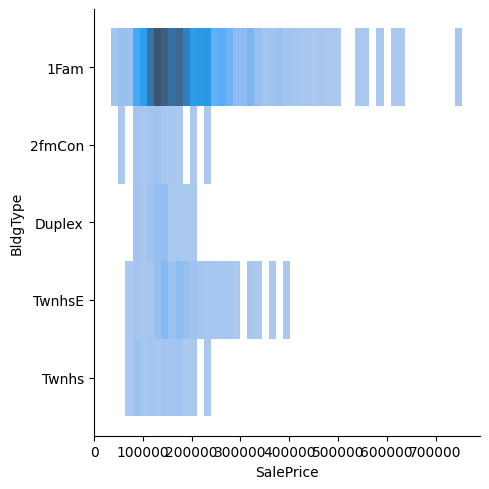

In [7]:
plt.figure(figsize=(20,10))

sns.displot(data,x='SalePrice', y='BldgType',kind='hist')

<Axes: xlabel='SalePrice', ylabel='YearBuilt'>

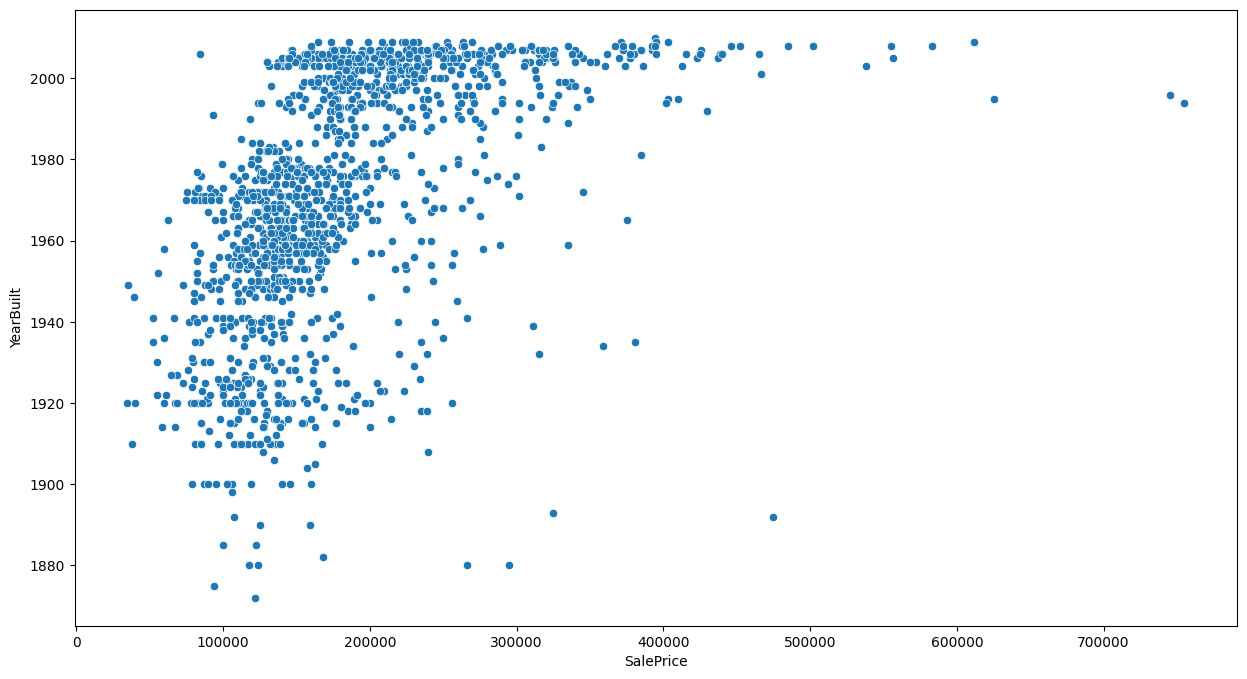

In [11]:

plt.figure(figsize=(15,8))
sns.scatterplot(data,x='SalePrice',y='YearBuilt')

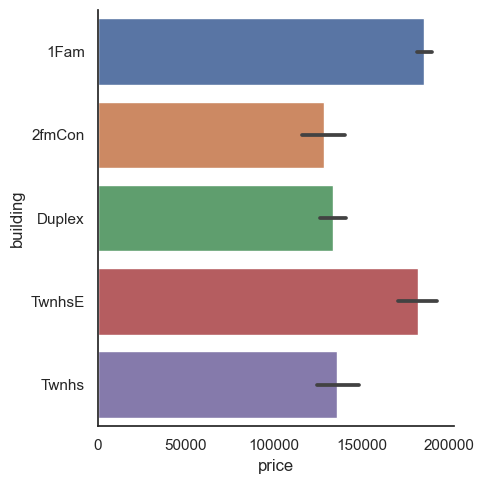

In [12]:
sns.set(style="white",)
g = sns.catplot(x='SalePrice',
                y= 'BldgType',
                #hue='BldgType',
                data=data,
                kind='bar',
                #ci=None,
                   )
g.set_axis_labels("price", "building")
plt.show()

In [23]:
data.SalePrice.corr(data[''])

ValueError: could not convert string to float: 'RL'

In [22]:
data.isna().value_counts().index[0]

(False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
pre.Information(data)


 There is : 1460  Nulls, Representing 1.00 % of The Data

 There is : 0  Duplicated, Representing 0.00 % of The Data

 Numerical Columns : {'Id': 'Continuous', 'MSSubClass': 'Continuous', 'LotFrontage': 'Continuous', 'LotArea': 'Continuous', 'OverallQual': 'Discrete', 'OverallCond': 'Discrete', 'YearBuilt': 'Continuous', 'YearRemodAdd': 'Continuous', 'MasVnrArea': 'Continuous', 'BsmtFinSF1': 'Continuous', 'BsmtFinSF2': 'Continuous', 'BsmtUnfSF': 'Continuous', 'TotalBsmtSF': 'Continuous', '1stFlrSF': 'Continuous', '2ndFlrSF': 'Continuous', 'LowQualFinSF': 'Continuous', 'GrLivArea': 'Continuous', 'BsmtFullBath': 'Discrete', 'BsmtHalfBath': 'Discrete', 'FullBath': 'Discrete', 'HalfBath': 'Discrete', 'BedroomAbvGr': 'Discrete', 'KitchenAbvGr': 'Discrete', 'TotRmsAbvGrd': 'Continuous', 'Fireplaces': 'Discrete', 'GarageYrBlt': 'Continuous', 'GarageCars': 'Discrete', 'GarageArea': 'Continuous', 'WoodDeckSF': 'Continuous', 'OpenPorchSF': 'Continuous', 'EnclosedPorch': 'Continuous', '3SsnPorch

,Feature,Unique_Values,No.OfUniqueValues,DataType,NoOfNulls,Nulls %
0,Id,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1460,int64,0,0
1,MSSubClass,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,...",15,int64,0,0
2,MSZoning,"[RL, RM, C (all), FV, RH]",5,object,0,0
3,LotFrontage,"[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, nan...",110,float64,259,17
4,LotArea,"[8450, 9600, 11250, 9550, 14260, 14115, 10084,...",1073,int64,0,0
5,Street,"[Pave, Grvl]",2,object,0,0
6,Alley,"[nan, Grvl, Pave]",2,object,1369,93
7,LotShape,"[Reg, IR1, IR2, IR3]",4,object,0,0
8,LandContour,"[Lvl, Bnk, Low, HLS]",4,object,0,0
9,Utilities,"[AllPub, NoSeWa]",2,object,0,0


In [9]:

cat=pd.DataFrame(data[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']])
#cat.head()
cat = cat.apply(lambda x:x.fillna(x.value_counts().index[0]))
#cat.HomePlanet.fillna(value='Mars',inplace=True)
#cat.Destination.fillna(value='PSO J318.5-22',inplace=True)
#cat.VIP.fillna(value='False',inplace=True)
cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
1,RL,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,BrkFace,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
2,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
3,RL,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,BrkFace,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Abnorml
4,RL,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal


In [10]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          1460 non-null   object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1460 non-null   object
 18  ExterQual      1460 non-null

In [14]:
num=pd.DataFrame(data[[ 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']])
num = num.apply(lambda x:x.fillna(x.median()))
#num.isna().value_counts()
num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


In [ ]:
one_hot_encoded_data = pd.get_dummies(data2, columns = ['HomePlanet', 'CryoSleep','VIP','Destination','Cabin_side'],drop_first=True)
one_hot_encoded_data.head()

In [12]:
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [15]:
data2=pd.concat([cat,num,data['SalePrice']], axis=1, join='outer')
data2

NameError: name 'cat' is not defined

In [37]:
data2.SalePrice.value_counts().values.max()

20

In [16]:
num.corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.356718,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.081396,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
LotFrontage,-0.356718,1.000000,0.304522,0.234812,-0.053281,0.116685,0.083348,0.178469,0.214367,0.042463,0.124098,0.363472,0.413773,0.072388,0.037469,0.368007,0.090343,-0.006979,0.180534,0.047222,0.236840,-0.004905,0.320518,0.233221,0.062996,0.269539,0.323511,0.075542,0.137014,0.010287,0.061945,0.037655,0.180819,-0.000255,0.010451,0.006380
LotArea,-0.139781,0.304522,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.025865,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
OverallQual,0.032628,0.234812,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.514231,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
OverallCond,-0.059316,-0.053281,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.306276,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
YearBuilt,0.027850,0.116685,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.777182,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
YearRemodAdd,0.040581,0.083348,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.616444,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
MasVnrArea,0.023573,0.178469,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,-0.071330,0.113862,0.360067,0.339850,0.173800,-0.068628,0.388052,0.083010,0.027403,0.272999,0.199108,0.102775,-0.038450,0.279568,0.247015,0.244444,0.361945,0.370884,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317
BsmtFinSF1,-0.069836,0.214367,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.148782,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359
BsmtFinSF2,-0.065649,0.042463,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.087684,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706


In [57]:
pre.Information(data2)


 There is : 0  Nulls, Representing 0.00 % of The Data

 There is : 0  Duplicated, Representing 0.00 % of The Data

 Numerical Columns : {'MSSubClass': 'Continuous', 'LotFrontage': 'Continuous', 'LotArea': 'Continuous', 'OverallQual': 'Discrete', 'OverallCond': 'Discrete', 'YearBuilt': 'Continuous', 'YearRemodAdd': 'Continuous', 'MasVnrArea': 'Continuous', 'BsmtFinSF1': 'Continuous', 'BsmtFinSF2': 'Continuous', 'BsmtUnfSF': 'Continuous', 'TotalBsmtSF': 'Continuous', '1stFlrSF': 'Continuous', '2ndFlrSF': 'Continuous', 'LowQualFinSF': 'Continuous', 'GrLivArea': 'Continuous', 'BsmtFullBath': 'Discrete', 'BsmtHalfBath': 'Discrete', 'FullBath': 'Discrete', 'HalfBath': 'Discrete', 'BedroomAbvGr': 'Discrete', 'KitchenAbvGr': 'Discrete', 'TotRmsAbvGrd': 'Continuous', 'Fireplaces': 'Discrete', 'GarageYrBlt': 'Continuous', 'GarageCars': 'Discrete', 'GarageArea': 'Continuous', 'WoodDeckSF': 'Continuous', 'OpenPorchSF': 'Continuous', 'EnclosedPorch': 'Continuous', '3SsnPorch': 'Continuous', 'Scree

,Feature,Unique_Values,No.OfUniqueValues,DataType,NoOfNulls,Nulls %
0,MSSubClass,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,...",15,int64,0,0
1,LotFrontage,"[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, 69....",110,float64,0,0
2,LotArea,"[8450, 9600, 11250, 9550, 14260, 14115, 10084,...",1073,int64,0,0
3,OverallQual,"[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]",10,int64,0,0
4,OverallCond,"[5, 8, 6, 7, 4, 2, 3, 9, 1]",9,int64,0,0
...,...,...,...,...,...,...
240,SaleCondition_AdjLand,"[False, True]",2,bool,0,0
241,SaleCondition_Alloca,"[False, True]",2,bool,0,0
242,SaleCondition_Family,"[False, True]",2,bool,0,0
243,SaleCondition_Normal,"[True, False]",2,bool,0,0


# Encoding

In [44]:
one_hot_encoded_data = pd.get_dummies(data2, columns = cat.columns ,drop_first=True)
one_hot_encoded_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,False,False,True,False,True,False,False

In [46]:
data2=pd.concat([cat,one_hot_encoded_data], axis=1, join='outer')
#data2['Transported']=data['Transported']
data2.drop(cat.columns,axis=1, inplace=True)
data2.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,False,False,True,False,True,False,False

In [47]:
X=data2.drop('SalePrice',axis=1)
y=pd.array(data2['SalePrice'])

# Baseline Model 

In [38]:
from sklearn.model_selection import cross_val_predict,cross_val_score,cross_validate,  train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


RS=42  #standerizing random_state to 42 

In [39]:
lr=LinearRegression()
rf=RandomForestRegressor()

# Train-Test-Validation Split

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state = 42)

In [51]:
print('x_train Shape:',x_train.shape,'y_train Shape:',y_train.shape)

x_train Shape: (1022, 244) y_train Shape: (1022,)


In [52]:
x_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
135,20,80.0,10400,7,6,1970,1970,288.0,0,0,1304,1304,1682,0,0,1682,0,0,2,0,3,1,7,1,1970.0,2,530,98,0,0,0,0,0,0,5,2008,False,False,True,False,True,False,False,False,True,Fal

In [53]:
lr.fit(x_train, y_train)

LinearRegression()

In [54]:
lr.score(x_train,y_train)

0.9360237261044336

# Cross Validation 

In [ ]:
RS=42

In [24]:
lrParams = {
    
}
n_estimators=100, *,  
max_depth=None, min_samples_split=2, min_samples_leaf=1,
min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None,
min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, 
random_state=None, , warm_start=False, 
ccp_alpha=0.0, max_samples=None)
rfParams = {
    'criterion': ['squared_error'],
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': range(2,5),
    'min_samples_leaf': range(5,10),
    'min_samples_split': [2,4],
    'verbose': [2],
    'n_estimators': [100],
    'random_state':[RS]
}

SyntaxError: unmatched ')' (462882242.py, line 9)

In [75]:
rfParams = {
    'criterion': ['squared_error'],
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': range(2,5),
    'min_samples_leaf': range(5,10),
    'min_samples_split': [2,4],
    'verbose': [2],
    'n_estimators': [100],
    'random_state':[RS]
}

In [76]:
rfCV= GridSearchCV(rf, rfParams, cv=10, n_jobs=3)
rfCV.fit(x_train,y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=3,
             param_grid={'bootstrap': [True], 'criterion': ['squared_error'],
                         'max_depth': [90, 100, 110],
                         'max_features': range(2, 5),
                         'min_samples_leaf': range(5, 10),
                         'min_samples_split': [2, 4], 'n_estimators': [100],
                         'random_state': [42], 'verbose': [2]})

In [79]:
rfCV.best_score_

0.657674552785257

# Submission

In [115]:
test=pd.read_csv(r'C:\Users\ritam\Documents\playground\Scripts\house-prices-advanced-regression-techniques\test.csv')


In [116]:

cat1=pd.DataFrame(test[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']])
#cat.head()
cat1 = cat1.apply(lambda x:x.fillna(x.value_counts().index[0]))
#cat.HomePlanet.fillna(value='Mars',inplace=True)
#cat.Destination.fillna(value='PSO J318.5-22',inplace=True)
#cat.VIP.fillna(value='False',inplace=True)
cat1

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RH,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
1,RL,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Gar2,WD,Normal
2,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
3,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
4,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,Gable,CompShg,CemntBd,CmentBd,BrkFace,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
1455,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,Gable,CompShg,CemntBd,CmentBd,BrkFace,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,CarPort,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Abnorml
1456,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Detchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Abnorml
1457,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,Gable,CompShg,HdBoard,Wd Shng,BrkFace,TA,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal


In [117]:
cat1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1459 non-null   object
 1   Street         1459 non-null   object
 2   Alley          1459 non-null   object
 3   LotShape       1459 non-null   object
 4   LandContour    1459 non-null   object
 5   Utilities      1459 non-null   object
 6   LotConfig      1459 non-null   object
 7   LandSlope      1459 non-null   object
 8   Neighborhood   1459 non-null   object
 9   Condition1     1459 non-null   object
 10  Condition2     1459 non-null   object
 11  BldgType       1459 non-null   object
 12  HouseStyle     1459 non-null   object
 13  RoofStyle      1459 non-null   object
 14  RoofMatl       1459 non-null   object
 15  Exterior1st    1459 non-null   object
 16  Exterior2nd    1459 non-null   object
 17  MasVnrType     1459 non-null   object
 18  ExterQual      1459 non-null

In [118]:
num1=pd.DataFrame(test[[ 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']])
num1 = num1.apply(lambda x:x.fillna(x.median()))
#num.isna().value_counts()
num1.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,0,0,6,2010
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,0,144,0,0,1,2010


In [119]:
one_hot_encoded_data1 = pd.get_dummies(test, columns = cat1.columns ,drop_first=True)
one_hot_encoded_data1

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False

In [120]:
test=pd.concat([cat1,one_hot_encoded_data1], axis=1, join='outer')
test.drop(cat1.columns,axis=1, inplace=True)
test

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False

In [121]:
test.drop('Id',axis=1,inplace=True)

In [122]:
test_pred=pd.DataFrame()
test_pred['SalePrice']=pd.DataFrame(rfCV.predict(test))
test_pred

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Condition2_RRAe
- Condition2_RRAn
- Condition2_RRNn
- Electrical_Mix
- Exterior1st_ImStucc
- ...


In [ ]:
Condition2:
       {'Feedr':1,
       'Norm':2,
       'RRNn':3,
       'RRAn':4,
       'PosN':5,
       'PosA':6,
       'RRNe':7,
       'RRAe':8}

In [ ]:
Condition1: 
       ['Artery',
       'Feedr',
       'Norm',
       'RRNn',
       'RRAn',
       'PosN',
       'PosA',
       'RRNe',
       'RRAe']


In [ ]:
Exterior1st:

       {'AsbShng':1,
       'AsphShn':2,
       'BrkComm':3,
       'BrkFace':4,
       'CBlock':5,
       'CemntBd':6,
       'HdBoard':7,
       'ImStucc':8,
       'MetalSd':9,
       'Other':10,
       'Plywood':11,
       'PreCast':12,
       'Stone':13,
       'Stucco':14,
       'VinylSd':15,
       'Wd Sdng':16,
       'WdShing':17 }


In [134]:
OED1={'Feedr':1,
       'Norm':2,
       'RRNn':3,
       'RRAn':4,
       'PosN':5,
       'PosA':6,
       'RRNe':7,
       'RRAe':8}
OED2={'AsbShng':1,
       'AsphShn':2,
       'BrkComm':3,
       'BrkFace':4,
       'CBlock':5,
       'CemntBd':6,
       'HdBoard':7,
       'ImStucc':8,
       'MetalSd':9,
       'Other':10,
       'Plywood':11,
       'PreCast':12,
       'Stone':13,
       'Stucco':14,
       'VinylSd':15,
       'Wd Sdng':16,
       'WdShing':17 }

OED3={ 'Feedr':1,
       'Norm':2,
       'RRNn':3,
       'RRAn':4,
       'PosN':5,
       'PosA':6,
       'RRNe':7,
       'RRAe':8}


test.replace(OED1,inplace=True)
test
#one_hot_encoded_data1 = pd.get_dummies(test, columns = cat1.columns ,drop_first=True)
#one_hot_encoded_data1

AttributeError: 'NoneType' object has no attribute 'replace'

In [135]:
test.replace(OED1,inplace=True)
test


AttributeError: 'NoneType' object has no attribute 'replace'

# Gradient Boosting (LGM VS XGB)

In [ ]:
from sklearn.ensemble import 